In [1]:
# import pandas for data handling
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords = stopwords.words('english')
from nltk import word_tokenize
from nltk.corpus import wordnet
import numpy as np

# Libraries for strings
import string
# Regular Expression Library
import re

# Import text vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Import classifiers
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors

# Import ML helper function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Import metrics to evaluate model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emilychiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# import data, loading data into dataframe # extract data
df = pd.read_csv('dem-vs-rep-tweets.csv') #chunksize, then save to df
print("shape", df.shape)  # print shape to see how data formated
# (86460, 3), tuple representing the dimensionality (rows/columns) of dataframe

shape (86460, 3)


In [3]:
print("head", df.head()) 
# shows beginning of file

head       Party         Handle                                              Tweet
0  Democrat  RepDarrenSoto  Today, Senate Dems vote to #SaveTheInternet. P...
1  Democrat  RepDarrenSoto  RT @WinterHavenSun: Winter Haven resident / Al...
2  Democrat  RepDarrenSoto  RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3  Democrat  RepDarrenSoto  RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4  Democrat  RepDarrenSoto  RT @Vegalteno: Hurricane season starts on June...


In [4]:
# check nulls and duplicates
print("nulls #:", df.isnull().sum())
# Party     0
# Handle    0
# Tweet     0
# dtype: int64

nulls #: Party     0
Handle    0
Tweet     0
dtype: int64


In [5]:
print("duplicates #:", df.duplicated().sum())
# found 57 duplicates

duplicates #: 57


In [6]:
# remove duplicates, transform/clean data
df.drop_duplicates(inplace=True) # drop dupes & reassign to df
print("current # of duplicates:", df.duplicated().sum())

current # of duplicates: 0


In [26]:
# finding class balance
print(df.Party.value_counts())
# Republican    44392
# Democrat      42068

# Republican    44362
#Democrat      42041

Republican    44362
Democrat      42041
Name: Party, dtype: int64


In [27]:
# lowercase all words function
def make_lower(a_string):
    return a_string.lower()

In [28]:
# remove all punctuation function
def remove_punctuation(a_string):    
    a_string = re.sub(r'[^\w\s]','',a_string)
    return a_string

In [29]:
# remove stopwords function
def remove_stopwords(a_string):
    # Break the sentence down into a list of words
    words = word_tokenize(a_string)
    # Make a list to append valid words into
    valid_words = []
    # Loop through all the words
    for word in words:
        # Check if word is not in stopwords
        if word not in stopwords:
            # If word not in stopwords, append to our valid_words
            valid_words.append(word)
    # Join the list of words together into a string
    a_string = ' '.join(valid_words)
    return a_string

In [30]:
# build text processing pipeline # transform/cleaning data
def text_pipeline(input_string):
    input_string = make_lower(input_string)
    input_string = remove_punctuation(input_string)
    #input_string = lem_with_pos_tag(input_string)
    input_string = remove_stopwords(input_string)    
    return input_string

In [31]:
# create new column to store cleaned version of tweet
df['message_clean'] = df['Tweet'].apply(text_pipeline)

In [32]:
print("ORIGINAL TEXT\n:", df['Tweet'][0])

ORIGINAL TEXT
: Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L


In [33]:
print("CLEANED TEXT\n:", df['message_clean'][0])

CLEANED TEXT
: today senate dems vote savetheinternet proud support similar netneutrality legislation house httpstcon3tggdlu1l


In [34]:
# # define data
X = df['message_clean'].values

Y = df['Party'].values

In [35]:
# # Initialize our vectorizer
vectorizer = TfidfVectorizer(min_df=2)
# requires that each feature occur at least twice in the training data

In [36]:
# #  makes vocab matrix
vectorizer.fit(X)

TfidfVectorizer(min_df=2)

In [37]:
# # transforms documents into vectors
X = vectorizer.transform(X)

In [38]:
print(X.shape, type(X))
# #(86460, 132962) <class 'scipy.sparse.csr.csr_matrix'>
#(86403, 31830) <class 'scipy.sparse.csr.csr_matrix'>

(86403, 31830) <class 'scipy.sparse.csr.csr_matrix'>


In [39]:
# function to test and evaluate models
def build_and_eval_model(model, X, Y):
    print("Running report for model:", model)
    
    # # Split data into testing and training within function (not global variable)
    X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.2, random_state=42)
    # local variables used within function
    
    # fit model
    model.fit(X_train, Y_train)
    
    # predicting results based on testing data
    Y_pred = model.predict(X_test)
    # Make predicted probabilites of our testing data

    # Get the evaluation metrics 
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))
    # y_test are true class labels and y_pred are predicted class labels in test-set, don't use train data
    
    f1score = f1_score(Y_test, Y_pred, average='macro')
    print('macro F-1 score : {}'.format(np.round(f1score,5)))
    
    # compare the train-set and test-set accuracy to check for overfitting 
    Y_pred_train = model.predict(X_train) 
    print('Training set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, Y_pred_train)))
    print('Test set accuracy score: {:.4f}'.format(model.score(X_test, Y_test)))

    # print classification report 
    print(metrics.classification_report(Y_test, Y_pred))
        
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model, 
                                  X=X_test, 
                                  Y_true=Y_test, 
                                  ax=ax)
    
    cm = confusion_matrix(Y_test, Y_pred)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    
    
    # print classification accuracy, same as test set score & model accuracy score
    classification_accuracy = (cm[0,0] + cm[1,1]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('model classification accuracy : {0:0.4f}'.format(classification_accuracy))
    
    # print classification error
    classification_error = (cm[0,1] + cm[1,0]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('model classification error : {0:0.4f}'.format(classification_error))

    # return the fitted model
    return model


Running report for model: MultinomialNB(alpha=0.05)
Model accuracy score: 0.8111
macro F-1 score : 0.81082
Training set accuracy score: 0.8835
Test set accuracy score: 0.8111
              precision    recall  f1-score   support

    Democrat       0.81      0.79      0.80      8407
  Republican       0.81      0.83      0.82      8874

    accuracy                           0.81     17281
   macro avg       0.81      0.81      0.81     17281
weighted avg       0.81      0.81      0.81     17281

Confusion matrix

 [[6663 1744]
 [1520 7354]]

True Positives(TP) =  6663

True Negatives(TN) =  7354

False Positives(FP) =  1744

False Negatives(FN) =  1520
model classification accuracy : 0.8111
model classification error : 0.1889


MultinomialNB(alpha=0.05)

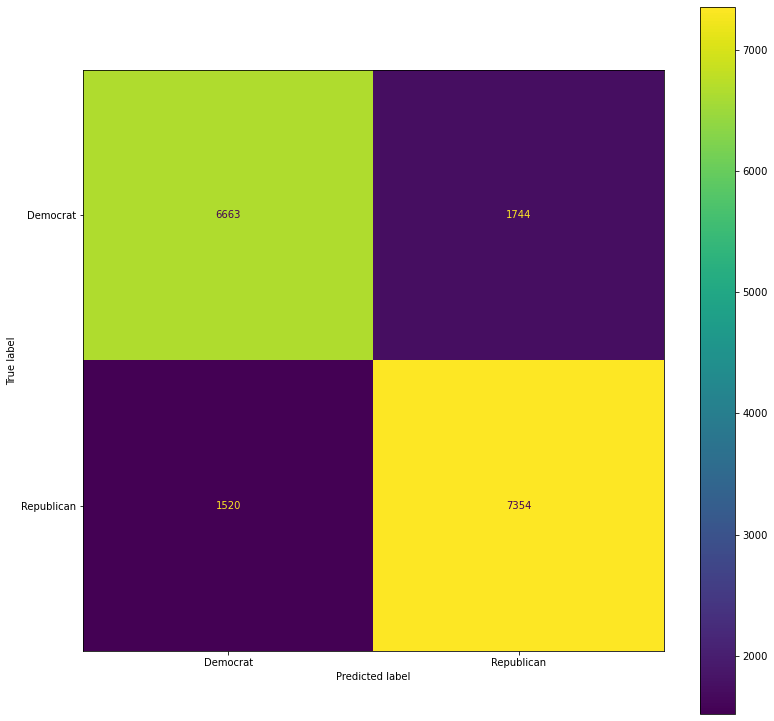

In [40]:
# # Initalize model # load data (training classifier using cleaned data)
mnb = MultinomialNB(alpha=.05)
build_and_eval_model(mnb, X, Y)

#Model Accuracy: 0.811180
#Model Accuracy: 0.811122 (with min_df=2)

Running report for model: LogisticRegression()


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model accuracy score: 0.7910
macro F-1 score : 0.79083
Training set accuracy score: 0.8569
Test set accuracy score: 0.7910
              precision    recall  f1-score   support

    Democrat       0.79      0.78      0.78      8407
  Republican       0.79      0.80      0.80      8874

    accuracy                           0.79     17281
   macro avg       0.79      0.79      0.79     17281
weighted avg       0.79      0.79      0.79     17281

Confusion matrix

 [[6561 1846]
 [1765 7109]]

True Positives(TP) =  6561

True Negatives(TN) =  7109

False Positives(FP) =  1846

False Negatives(FN) =  1765
model classification accuracy : 0.7910
model classification error : 0.2090


LogisticRegression()

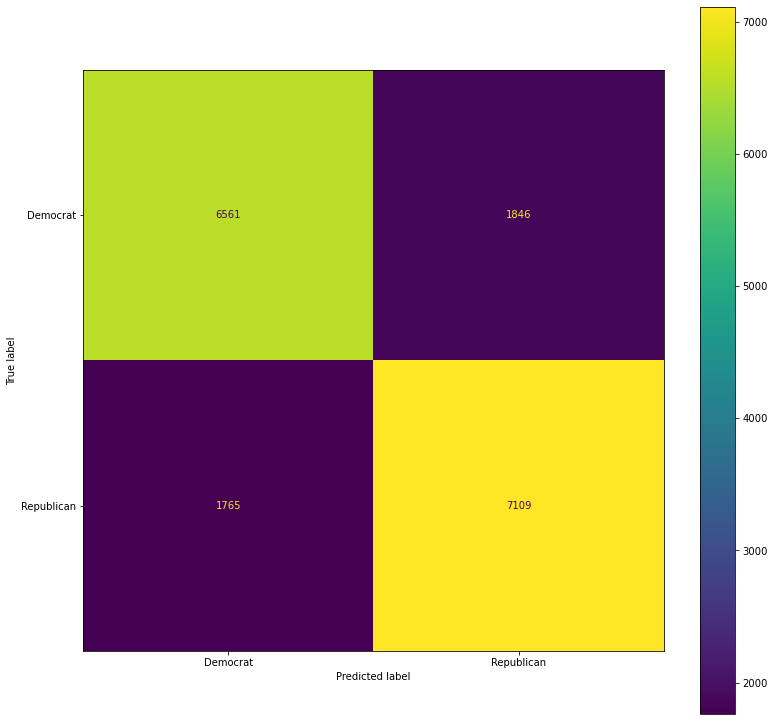

In [41]:
lr = LogisticRegression()
build_and_eval_model(lr, X, Y)

Running report for model: RandomForestClassifier()
Model accuracy score: 0.7489
macro F-1 score : 0.74822
Training set accuracy score: 0.9961
Test set accuracy score: 0.7489
              precision    recall  f1-score   support

    Democrat       0.75      0.72      0.74      8407
  Republican       0.74      0.78      0.76      8874

    accuracy                           0.75     17281
   macro avg       0.75      0.75      0.75     17281
weighted avg       0.75      0.75      0.75     17281

Confusion matrix

 [[6036 2371]
 [1969 6905]]

True Positives(TP) =  6036

True Negatives(TN) =  6905

False Positives(FP) =  2371

False Negatives(FN) =  1969
model classification accuracy : 0.7489
model classification error : 0.2511


RandomForestClassifier()

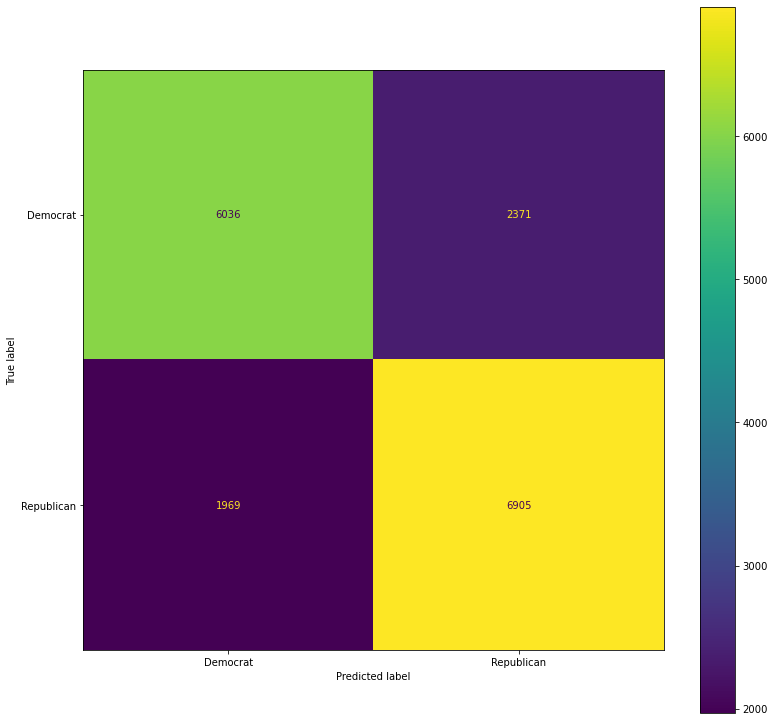

In [42]:
rf = RandomForestClassifier()
build_and_eval_model(rf, X, Y)

Running report for model: DecisionTreeClassifier(random_state=0)
Model accuracy score: 0.6865
macro F-1 score : 0.68597
Training set accuracy score: 0.9961
Test set accuracy score: 0.6865
              precision    recall  f1-score   support

    Democrat       0.68      0.66      0.67      8407
  Republican       0.69      0.71      0.70      8874

    accuracy                           0.69     17281
   macro avg       0.69      0.69      0.69     17281
weighted avg       0.69      0.69      0.69     17281

Confusion matrix

 [[5583 2824]
 [2594 6280]]

True Positives(TP) =  5583

True Negatives(TN) =  6280

False Positives(FP) =  2824

False Negatives(FN) =  2594
model classification accuracy : 0.6865
model classification error : 0.3135


DecisionTreeClassifier(random_state=0)

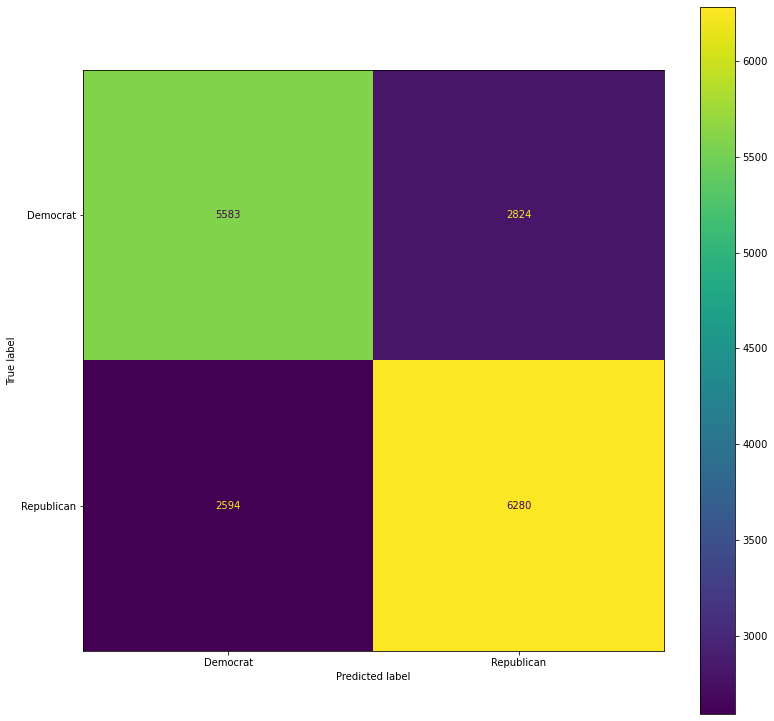

In [43]:
dt = DecisionTreeClassifier(random_state=0)
build_and_eval_model(dt, X, Y)

In [45]:
svc = svm.SVC()
build_and_eval_model(svc, X, Y)
# from sklearn.svm import SVC
# svc = SVC(kernel='linear')

NameError: name 'svm' is not defined

Running report for model: KNeighborsClassifier()
Model accuracy score: 0.5662
macro F-1 score : 0.56357
Training set accuracy score: 0.7383
Test set accuracy score: 0.5662
              precision    recall  f1-score   support

    Democrat       0.56      0.50      0.53      8407
  Republican       0.57      0.63      0.60      8874

    accuracy                           0.57     17281
   macro avg       0.57      0.56      0.56     17281
weighted avg       0.57      0.57      0.56     17281

Confusion matrix

 [[4218 4189]
 [3307 5567]]

True Positives(TP) =  4218

True Negatives(TN) =  5567

False Positives(FP) =  4189

False Negatives(FN) =  3307
model classification accuracy : 0.5662
model classification error : 0.4338


KNeighborsClassifier()

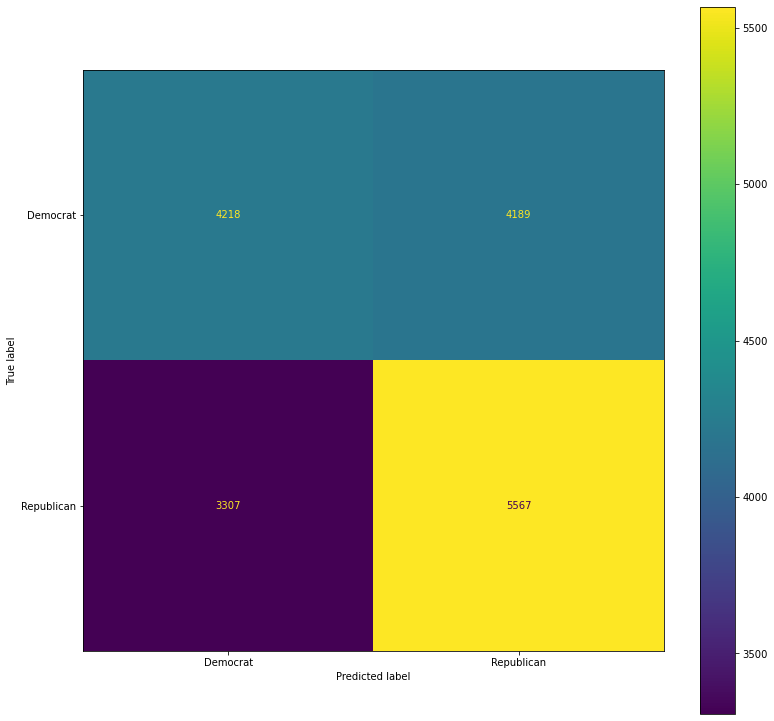

In [46]:
# supervised learning
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
build_and_eval_model(knn, X, Y)